In [1]:
# load packages
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.__version__

'1.12.0'

# Classifying newswires: a multi-class classification example
---- 

Here, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification".

## The Reuters dataset

We will be working with ```Reuters dataset```, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

In [2]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000) # consider only 10k most frequent words

In [3]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((8982,), (8982,), (2246,), (2246,))

In [4]:
# get word index mapping
word_index = reuters.get_word_index()

# get index to word mapping
# indices were offset by 3 to accomodate padding, start and unkown tokens
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

### For kicks, here's how you can quickly decode one of these reviews back to English words:

In [5]:
# get the real news data using this reverse index
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## Preparing data

In [6]:
# vectorize input features
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# vectorized training data
x_train = vectorize_sequences(train_data)

# vectorized test data
x_test = vectorize_sequences(test_data)

In [7]:
x_train[0], x_train[1]

(array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]))

In [8]:
x_test[0], x_test[1]

(array([0., 1., 1., ..., 0., 0., 0.]), array([0., 1., 1., ..., 0., 0., 0.]))

In [9]:
# vectorize labels
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)

# vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

In [10]:
one_hot_train_labels[0], one_hot_test_labels[0]

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

You can do the same using the built-in method.

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [13]:
one_hot_train_labels[0], one_hot_test_labels[0]

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

## Validating our approach

In [14]:
# split train data into train and validate set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## Building model

In [15]:
from tensorflow.keras import models, layers

In [16]:
# initiate model
model = models.Sequential()

# input layer
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))

# hidden layer
model.add(layers.Dense(64, activation="relu"))

# output layer
model.add(layers.Dense(46, activation="softmax"))

# compile model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# train model for 20 epochs in batches of 512 and validate on the validation set
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 234us/step - loss: 2.5549 - acc: 0.5373 - val_loss: 1.7009 - val_acc: 0.6370
Epoch 2/20
7982/7982 [==============================] - 1s 100us/step - loss: 1.4235 - acc: 0.7036 - val_loss: 1.3305 - val_acc: 0.7030
Epoch 3/20
7982/7982 [==============================] - 1s 101us/step - loss: 1.0786 - acc: 0.7636 - val_loss: 1.1590 - val_acc: 0.7560
Epoch 4/20
7982/7982 [==============================] - 1s 103us/step - loss: 0.8496 - acc: 0.8171 - val_loss: 1.0506 - val_acc: 0.7880
Epoch 5/20
7982/7982 [==============================] - 1s 102us/step - loss: 0.6679 - acc: 0.8582 - val_loss: 0.9808 - val_acc: 0.8020
Epoch 6/20
7982/7982 [==============================] - 1s 102us/step - loss: 0.5376 - acc: 0.8859 - val_loss: 0.9452 - val_acc: 0.8140
Epoch 7/20
7982/7982 [==============================] - 1s 99us/step - loss: 0.4279 - acc: 0.9090 - val_loss: 0.9091 - val_acc: 0.8250
E

## Visualize model performance

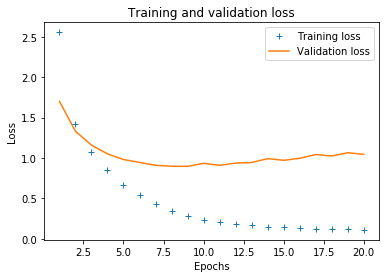

In [17]:
# access train loss and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# get epochs
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "+", label="Training loss")
plt.plot(epochs, val_loss, "-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

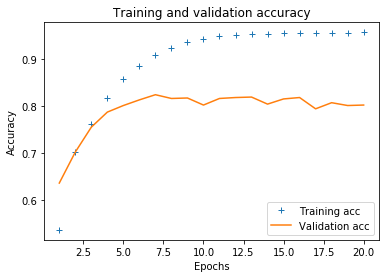

In [18]:
# access train accuracy and validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]

plt.plot(epochs, acc, "+", label="Training acc")
plt.plot(epochs, val_acc, "-", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs.

In [19]:
# re-initiate model
model = models.Sequential()

# input layer
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))

# hidden layer
model.add(layers.Dense(64, activation="relu"))

# output layer
model.add(layers.Dense(46, activation="softmax"))

# compile model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# train model for 20 epochs in batches of 512 and validate on the validation set
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=8,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 2s 193us/step - loss: 2.6170 - acc: 0.5164 - val_loss: 1.6717 - val_acc: 0.6340
Epoch 2/8
7982/7982 [==============================] - 1s 93us/step - loss: 1.3816 - acc: 0.7048 - val_loss: 1.2744 - val_acc: 0.7080
Epoch 3/8
7982/7982 [==============================] - 1s 91us/step - loss: 1.0271 - acc: 0.7840 - val_loss: 1.0992 - val_acc: 0.7630
Epoch 4/8
7982/7982 [==============================] - 1s 91us/step - loss: 0.8154 - acc: 0.8270 - val_loss: 1.0087 - val_acc: 0.7900
Epoch 5/8
7982/7982 [==============================] - 1s 99us/step - loss: 0.6463 - acc: 0.8653 - val_loss: 0.9444 - val_acc: 0.8000
Epoch 6/8
7982/7982 [==============================] - 1s 90us/step - loss: 0.5198 - acc: 0.8936 - val_loss: 0.9063 - val_acc: 0.8070
Epoch 7/8
7982/7982 [==============================] - 1s 89us/step - loss: 0.4209 - acc: 0.9116 - val_loss: 0.8679 - val_acc: 0.8120
Epoch 8/8
798

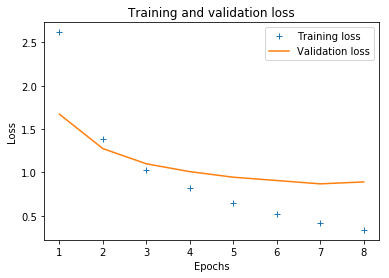

In [20]:
# access train loss and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# get epochs
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "+", label="Training loss")
plt.plot(epochs, val_loss, "-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

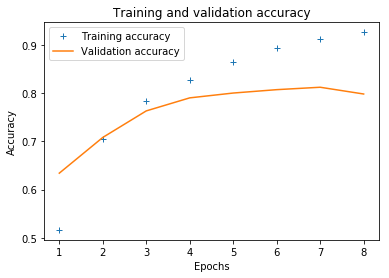

In [21]:
# access train accuracy and validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]

plt.plot(epochs, acc, "+", label="Training accuracy")
plt.plot(epochs, val_acc, "-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [22]:
# evaluate on test set
results = model.evaluate(x_test, one_hot_test_labels)
"loss = {}, and accuracy = {}".format(results[0], results[1])

2246/2246 [==============================] - 0s 93us/step


'loss = 0.991862693431647, and accuracy = 0.7769367764915405'


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, so our results seem pretty good, at least when compared to a random baseline.

We should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [23]:
# re-initiate model
model = models.Sequential()

# input layer
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))

# hidden layer
model.add(layers.Dense(4, activation="relu"))

# output layer
model.add(layers.Dense(46, activation="softmax"))

# compile model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# train model for 20 epochs in batches of 512 and validate on the validation set
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=8,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 2s 209us/step - loss: 3.2777 - acc: 0.3393 - val_loss: 2.8020 - val_acc: 0.3800
Epoch 2/8
7982/7982 [==============================] - 1s 94us/step - loss: 2.4652 - acc: 0.3993 - val_loss: 2.2871 - val_acc: 0.4240
Epoch 3/8
7982/7982 [==============================] - 1s 98us/step - loss: 2.0256 - acc: 0.5259 - val_loss: 1.9866 - val_acc: 0.5670
Epoch 4/8
7982/7982 [==============================] - 1s 89us/step - loss: 1.7297 - acc: 0.6055 - val_loss: 1.7799 - val_acc: 0.5930
Epoch 5/8
7982/7982 [==============================] - 1s 90us/step - loss: 1.5169 - acc: 0.6245 - val_loss: 1.6403 - val_acc: 0.6030
Epoch 6/8
7982/7982 [==============================] - 1s 88us/step - loss: 1.3674 - acc: 0.6481 - val_loss: 1.5469 - val_acc: 0.6360
Epoch 7/8
7982/7982 [==============================] - 1s 93us/step - loss: 1.2531 - acc: 0.6862 - val_loss: 1.5008 - val_acc: 0.6440
Epoch 8/8
798

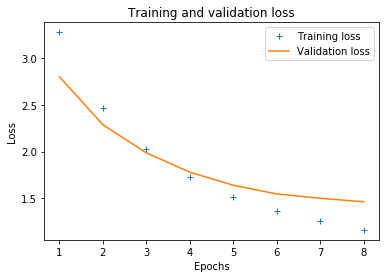

In [24]:
# access train loss and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# get epochs
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "+", label="Training loss")
plt.plot(epochs, val_loss, "-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

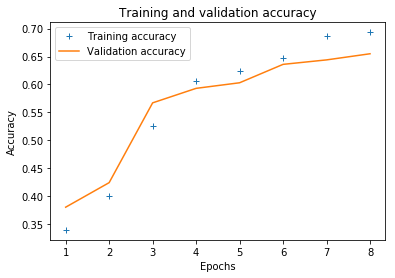

In [25]:
# access train accuracy and validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]

plt.plot(epochs, acc, "+", label="Training accuracy")
plt.plot(epochs, val_acc, "-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


Our network now seems to peak at ~65% test accuracy. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional.